In [112]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_relevance_2.0'
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.dirname(os.path.abspath(os.path.dirname("__file__"))))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Not a Google Colab session.
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_LLM_Contextual_Predictions


# **Central Europe floods (Bluesky): Exploratory Spatial Data Analysis**
In this notebook, let's look at the basic properties of the Bluesky data retrieved regarding the 2024 Central Europe floods.

In [113]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import stopwordsiso as siso
import matplotlib.pyplot as plt
from wordcloud import WordCloud
sns.set_style("ticks")

DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(DATA_PATH)

/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_LLM_Contextual_Predictions/data


## **1. Load data**
We directly load the data from our NLP pipeline that is run as follows.

```bash
python -m scripts.esda.nlp_analysis --input-file "./data/raw/2024_central_europe_floods/bsky_central_europe_gdf.parquet" --output-path "data/processed/2024_central_europe_floods"
```

In [114]:
# try reading as geoparquet, else fix geometry
try:
    europe_floods_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', '2024_central_europe_floods', 'bsky_central_europe_gdf_esda.parquet'))
except:
    europe_floods_gdf: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'processed', '2024_central_europe_floods', 'bsky_central_europe_gdf_esda.parquet'))
    europe_floods_gdf['geometry'] = gpd.GeoSeries.from_wkb(europe_floods_gdf['geometry'].values, crs=4326)
    europe_floods_gdf = gpd.GeoDataFrame(europe_floods_gdf, geometry='geometry', crs=4326)
    europe_floods_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', '2024_central_europe_floods', 'bsky_central_europe_gdf_esda.parquet'))

topics: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'processed', '2024_central_europe_floods', 'bsky_central_europe_gdf_topics.parquet'))
print(f'Total number of posts: {len(europe_floods_gdf)}')
print(f'Total number of posts with geometry: {len(europe_floods_gdf[~europe_floods_gdf.geometry.is_empty])}')
print(f'Total number of disaster-related posts: {len(europe_floods_gdf[europe_floods_gdf['disaster_related'] == 1])}')
print(f'Total number of disaster-related posts with geometry: {len(europe_floods_gdf[(europe_floods_gdf['disaster_related'] == 1) & (~europe_floods_gdf.geometry.is_empty)])}')
print(f'Columns: {europe_floods_gdf.columns.tolist()}')

# extract languages
europe_floods_gdf['language'] = europe_floods_gdf['langs'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
europe_floods_gdf['language'] = europe_floods_gdf['language'].apply(lambda x: x[:2] if isinstance(x, str) and len(x) > 2 else x)

# for ArcGIS visualisation - does not work anyway
# europe_floods_gdf[~europe_floods_gdf.geometry.is_empty].to_file(os.path.join(DATA_PATH, 'processed', '2024_central_europe_floods', 'bsky_central_europe_gdf_esda.gpkg'))

pd.DataFrame(europe_floods_gdf)

Total number of posts: 105767
Total number of posts with geometry: 25092
Total number of disaster-related posts: 23247
Total number of disaster-related posts with geometry: 11889
Columns: ['cid', 'uri', 'author_displayName', 'author_handle', 'author_did', 'createdAt', 'langs', 'text', 'replyCount', 'repostCount', 'likeCount', 'quoteCount', 'reply_parent_cid', 'reply_root_cid', 'image_thumbnails', 'image_fullsizes', 'urls', 'geocoded_dict', 'language', 'place', 'geometry', 'cleaned_text', 'topic_id', 'keywords', 'topic_label', 'p_anger', 'p_fear', 'p_joy', 'p_sadness', 'anger', 'fear', 'joy', 'sadness', 'no_emotion', 'disaster_related']


,cid,uri,author_displayName,author_handle,author_did,createdAt,langs,text,replyCount,repostCount,...,p_anger,p_fear,p_joy,p_sadness,anger,fear,joy,sadness,no_emotion,disaster_related
0,bafyreieyoe3qdxqyt6dzy4jgulbhmzabiapfwjoxb5qt7...,at://did:plc:gktgbtpiaukmvvoz2sjtmf7u/app.bsky...,Emma Jackson,artistemma.bsky.social,did:plc:gktgbtpiaukmvvoz2sjtmf7u,2024-09-05T00:29:19.356Z,[en],I saw flood of bots sliding in your dm. So it'...,0,0,...,0.208685,0.015405,0.754755,0.021155,False,False,True,False,False,0
1,bafyreiezsvxcgq4ykp5gymto5cxulr2wbo6fy74tblnqv...,at://did:plc:25p6t72qcfxn2h3fitll26lg/app.bsky...,Nookster,oldnook.bsky.social,did:plc:25p6t72qcfxn2h3fitll26lg,2024-09-05T00:27:31.623Z,[en],Yess I love Tales from the Loop and Things fro...,0,0,...,0.000898,0.000988,0.997171,0.000943,False,False,True,False,False,1
2,bafyreifjnjiek7dis53sbnfhztibfsndrmt4jeq6w5z4u...,at://did:plc:fniatkwrlwi3aosmwenmwo3g/app.bsky...,National Weather Service Alerts,skeetbot.watchedsky.social,did:plc:fniatkwrlwi3aosmwenmwo3g,2024-09-05T00:24:00Z,[en-US],NEW WEATHER ADVISORY: Flood Warning \n\n...The...,1,0,...,0.008617,0.969723,0.010946,0.010714,False,True,False,False,False,1
3,bafyreiakfvfskmzpy4ed3o4moiadqqc3fksoa5dttxmq2...,at://did:plc:fniatkwrlwi3aosmwenmwo3g/app.bsky...,National Weather Service Alerts,skeetbot.watchedsky.social,did:plc:fniatkwrlwi3aosmwenmwo3g,2024-09-05T00:11:00Z,[en-US],NEW WEATHER ADVISORY: Flood Advisory \n\n* WHA...,0,0,...,0.007115,0.971839,0.010073,0.010973,False,True,False,False,False,1
4,bafyreibleg767ap7ykqtpvib3uq3wp4wdbd67syzhq2lu...,at://did:plc:gaza65qf6kjan6tatqglnqm4/app.bsky...,๏ʀɪᴀᴍ,oriambr2.bsky.social,did:plc:gaza65qf6kjan6tatqglnqm4,2024-09-05T00:08:41.460Z,[pt],"Kkkkkkkkkkkkk Meu querido, as contas que têm a...",1,0,...,0.581557,0.125513,0.152228,0.140701,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105762,bafyreif4wrgbihx6yd5ubgqg4bwslvj6q676lunlkqyl7...,at://did:plc:s3ypdatszdn23lw6akca3euq/app.bsky...,.,kivintt.bsky.social,did:plc:s3ypdatszdn23lw6akca3euq,2024-09-30T23:55:30.813Z,[es],yo espero que estéis de broma y no os estéis t...,0,0,...,0.577057,0.313412,0.028920,0.080611,True,False,False,False,False,0
105763,bafyreieufslshu3wz6qx3m2xs5j74s37gropftruuutk7...,at://did:plc:g5p4xl3sdp7btcnhmvotvfgu/app.bsky...,Julzᶻ,polarishoto.bsky.social,did:plc:g5p4xl3sdp7btcnhmvotvfgu,2024-09-30T23:50:56.914Z,[es],Actualizando hoy hice planes de cosas y no mam...,0,0,...,0.042530,0.105643,0.567737,0.284090,False,False,True,False,False,0
105764,bafyreif6obp4dvxrddmqewvqz4bk3ie5x7i6672vga5ln...,at://did:plc:bfcxjpjvxoclpeq6dvsgwhmo/app.bsky...,,ojopelao07.bsky.social,did:plc:bfcxjpjvxoclpeq6dvsgwhmo,2024-09-30T23:40:20.870Z,[es],Esperamos que sea un chiste eso de que van a d...,0,0,...,0.642116,0.051581,0.020695,0.285608,True,False,False,False,False,0
105765,bafyreifj6fg7yskszhemrbxhplnlmyt7bru6nmhed52to...,at://did:plc:375uya6ihovptmvdmze5bney/app.bsky...,perritoquiboconhambre,kissvi.bsky.social,did:plc:375uya6ihovptmvdmze5bney,2024-09-30T23:38:43.647Z,[es],ah que ahora echáis el tarot y según eso las k...,1,0,...,0.022399,0.004769,0.969763,0.003069,False,False,True,False,False,0


In [115]:
topics

,Count,Name,Representation,Representative_Docs
0,9066,-1_advisory_flood_coastal_warning,"[advisory, flood, coastal, warning, at, weathe...",[NEW WEATHER ADVISORY: Coastal Flood Warning *...
1,46750,0_the_and_to_of,"[the, and, to, of, it, rain, in, damage, that,...",[I just hopped over to see how you were with t...
2,27570,1_que_de_eso_no,"[que, de, eso, no, la, es, en, el, lo, por]","[Eso es lo que está mal 🫤, Joé, pero es que sa..."
3,8502,2_und_die_der_regen,"[und, die, der, regen, das, ist, ich, nicht, h...","[Ich war der Wind, dachte sie. Der Wind im Him..."
4,4247,3_advisory_flood_weather_watchedsky,"[advisory, flood, weather, watchedsky, alerts,...",[NEW WEATHER ADVISORY: Flood Advisory * WHAT.....
5,2717,4_you_kidnapped_watched_save,"[you, kidnapped, watched, save, characters, tv...",[You‘ve been kidnapped. The characters from th...
6,1636,5_coastal_advisory_rip_for,"[coastal, advisory, rip, for, flood, inundatio...",[NEW WEATHER ADVISORY: Coastal Flood Advisory ...
7,1140,6_http_mixadoptable_male_female,"[http, mixadoptable, male, female, rescue, fro...",[Robin 🐕‍🦺Young female Husky mixAdoptable from...
8,935,7_edt_september_at_nws,"[edt, september, at, nws, details, additional,...",[Flood Warning issued September 27 at 4:16PM E...
9,793,8_het_regen_een_ik,"[het, regen, een, ik, en, de, maar, op, dat, met]",[Ok de dag van we hebben regen met regen en re...


Let's visualise the number of daily disaster-related posts.

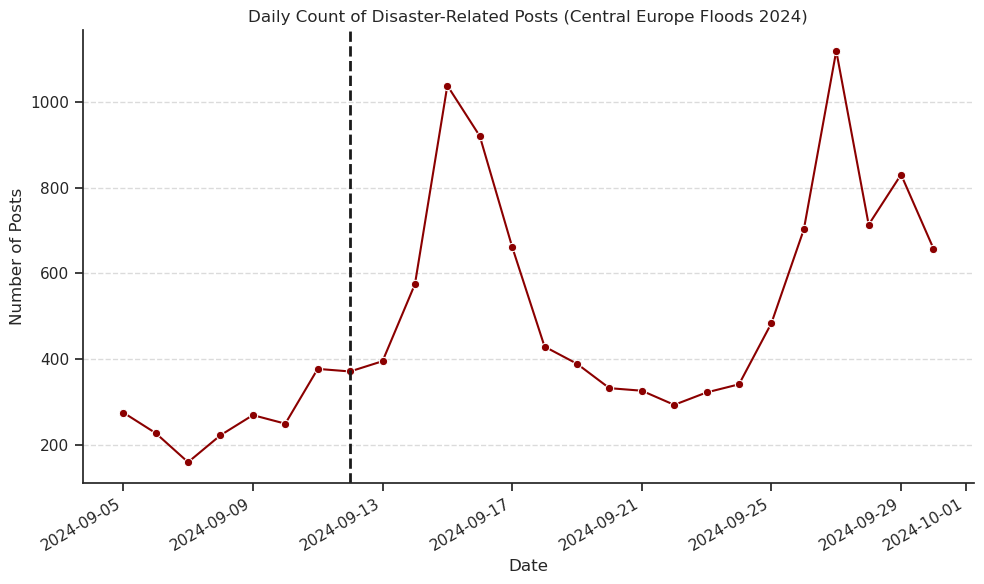

In [116]:
# 1. Ensure createdAt is datetime
europe_floods_gdf['createdAt'] = pd.to_datetime(europe_floods_gdf['createdAt'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# 2. Filter for disaster-related posts
disaster_df = europe_floods_gdf[europe_floods_gdf['disaster_related'] == 1]

# 3. Group by day and count posts, filling missing days with zero
daily_counts = (
    disaster_df
    .set_index('createdAt')
    .resample('D')
    .size()
    .asfreq('D', fill_value=0)
).reset_index(name='count')

# 4. Plot the time series
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_counts, x='createdAt', y='count', ax=ax, marker='o', color='darkred')
ax.set_title('Daily Count of Disaster-Related Posts (Central Europe Floods 2024)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.autofmt_xdate()
fig.tight_layout()

# 5. Add dashed line on September 12
sep12 = pd.to_datetime('2024-09-12')  # ← change year as needed
ax.axvline(sep12, color='k', linestyle='--', linewidth=2, label='Sep 12')

How about a wordcloud?

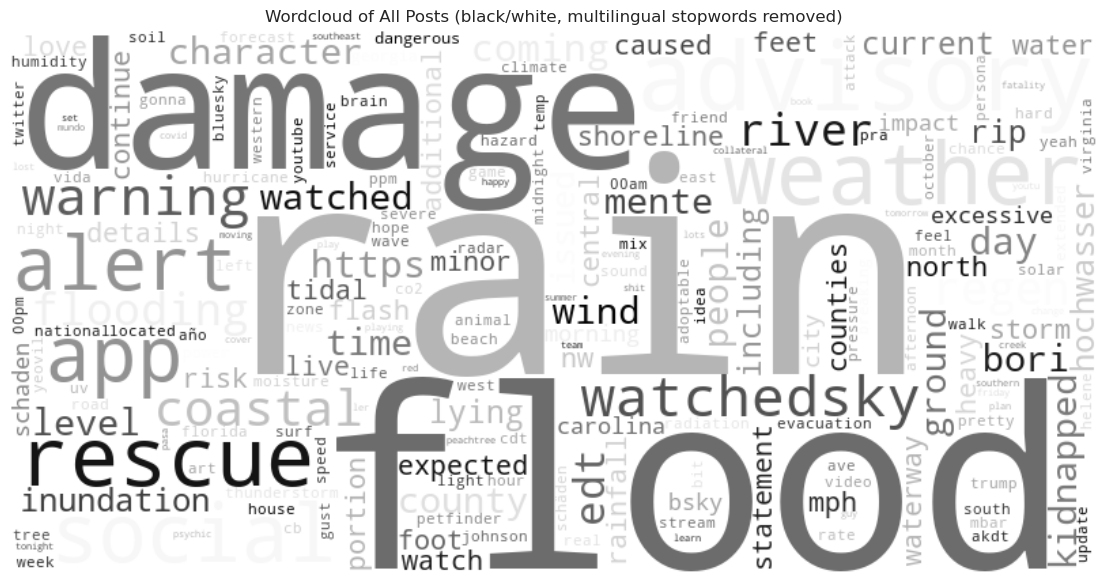

In [117]:
texts: list = europe_floods_gdf['text'].dropna().astype(str)

# concatenate all tweets into one large string, lowercase
all_text: list = " ".join(texts).lower()

# stop-words in ~200 languages
stopwords: list[str] = siso.stopwords(siso.langs())

# Generate the wordcloud
wc = WordCloud(
    width=800, 
    height=400,
    background_color='white',       # white canvas
    stopwords=stopwords,            # filter out all languages
    collocations=False,             # don’t show common bigrams like “new york”
    colormap='gray'
).generate(all_text)


plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of All Posts (black/white, multilingual stopwords removed)")
plt.tight_layout()
plt.show()

What about the languages?

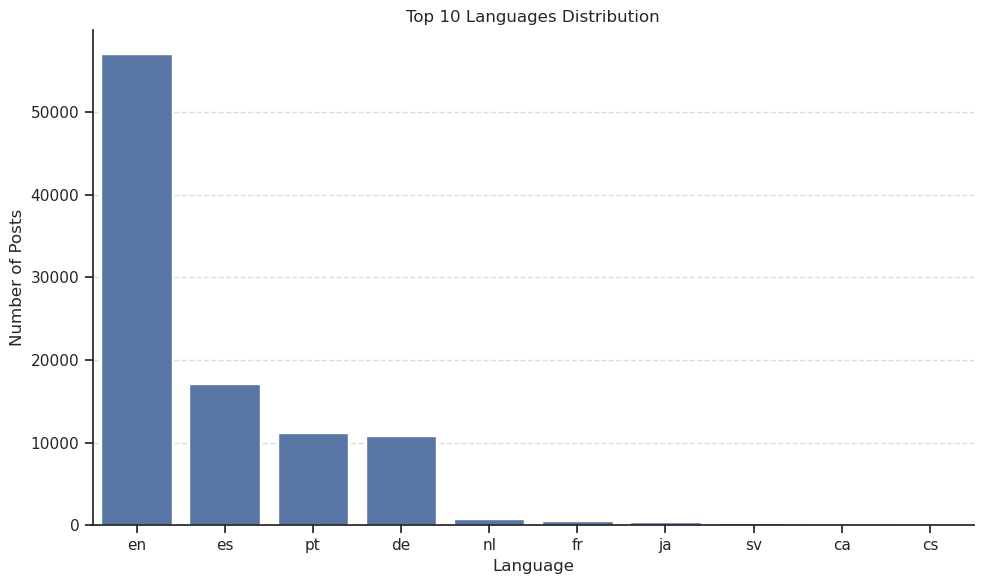

In [118]:
# 1. Compute top 10 language counts
lang_counts = (
    europe_floods_gdf['language']
    .value_counts()
    .nlargest(10)
    .reset_index()
)
lang_counts.columns = ['language', 'count']

# 2. Create the barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=lang_counts, x='language', y='count', ax=ax)
ax.set_title('Top 10 Languages Distribution')
ax.set_xlabel('Language')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

Next, we check the distribution of emotions.

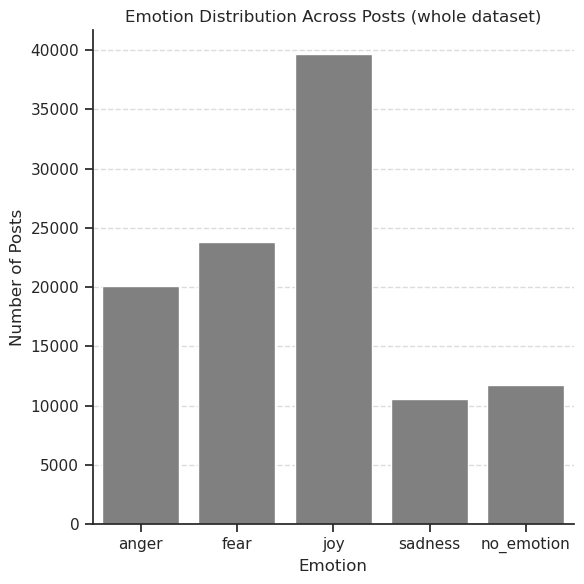

In [121]:
# 1. List your binary emotion columns
emotions = ['anger', 'fear', 'joy', 'sadness', 'no_emotion']

# 2. Sum up how many posts have each emotion
emotion_counts = (
    europe_floods_gdf[emotions]
    .sum()
    .reset_index()
)
emotion_counts.columns = ['emotion', 'count']

# 3. Plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=emotion_counts, x='emotion', y='count', ax=ax, color='gray')
ax.set_title('Emotion Distribution Across Posts (whole dataset)')
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

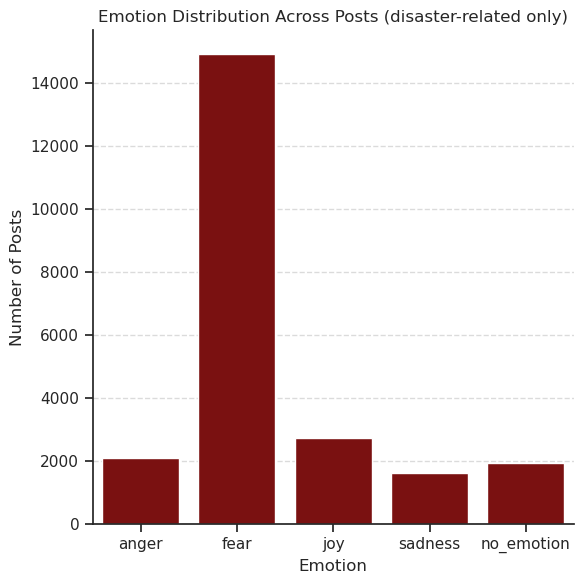

In [104]:
# 1. List your binary emotion columns
emotions = ['anger', 'fear', 'joy', 'sadness', 'no_emotion']

# 2. Sum up how many posts have each emotion
emotion_counts = (
    europe_floods_gdf[europe_floods_gdf['disaster_related']== 1][emotions]
    .sum()
    .reset_index()
)
emotion_counts.columns = ['emotion', 'count']

# 3. Plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=emotion_counts, x='emotion', y='count', ax=ax, color='darkred')
ax.set_title('Emotion Distribution Across Posts (disaster-related only)')
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

The mapping will be done in QGIS!